## Task-2 : Customer Segmentation

In [13]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
customers = pd.read_csv("data/customers.csv")
products = pd.read_csv("data/products.csv")
transactions = pd.read_csv("data/transactions.csv")

In [3]:
transactions.head

<bound method NDFrame.head of     TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0          T00001      C0199      P067  2024-08-25 12:38:23         1   
1          T00112      C0146      P067  2024-05-27 22:23:54         1   
2          T00166      C0127      P067  2024-04-25 07:38:55         1   
3          T00272      C0087      P067  2024-03-26 22:55:37         2   
4          T00363      C0070      P067  2024-03-21 15:10:10         3   
..            ...        ...       ...                  ...       ...   
995        T00496      C0118      P037  2024-10-24 08:30:27         1   
996        T00759      C0059      P037  2024-06-04 02:15:24         3   
997        T00922      C0018      P037  2024-04-05 13:05:32         4   
998        T00959      C0115      P037  2024-09-29 10:16:02         2   
999        T00992      C0024      P037  2024-04-21 10:52:24         1   

     TotalValue   Price  
0        300.68  300.68  
1        300.68  300.68  
2        300.68

## Merge customer and transaction data
### Add product categories to enhance features

In [4]:
customer_transactions = pd.merge(customers, transactions, on="CustomerID")

customer_transactions = pd.merge(
    customer_transactions, products[["ProductID", "Category"]], on="ProductID"
)

### Create a customer-product matrix

In [5]:
customer_product_matrix = customer_transactions.pivot_table(
    index="CustomerID", columns="ProductID", values="Quantity", aggfunc="sum", fill_value=0
)

### Standardize the matrix and compute similarity

In [6]:
scaler = StandardScaler()
scaled_matrix = scaler.fit_transform(customer_product_matrix)

similarity_matrix = cosine_similarity(scaled_matrix)

### Write a functionn to get top lookalikes for a given customer usign the similarity matrix and customer-product matrix

In [8]:
def get_lookalikes(customer_id, similarity_matrix, customer_product_matrix, top_n=3):
    customer_index = customer_product_matrix.index.get_loc(customer_id)
    similarity_scores = list(enumerate(similarity_matrix[customer_index]))
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    top_lookalikes = similarity_scores[1 : top_n + 1]  # Exclude the customer itself
    return [
        {"LookalikeID": customer_product_matrix.index[index], "SimilarityScore": score}
        for index, score in top_lookalikes
    ]

In [9]:
lookalike_map = {}
for customer_id in customer_product_matrix.index[:20]:
    lookalike_map[customer_id] = get_lookalikes(
        customer_id, similarity_matrix, customer_product_matrix
    )

### Visualize the results

#### Network Graph

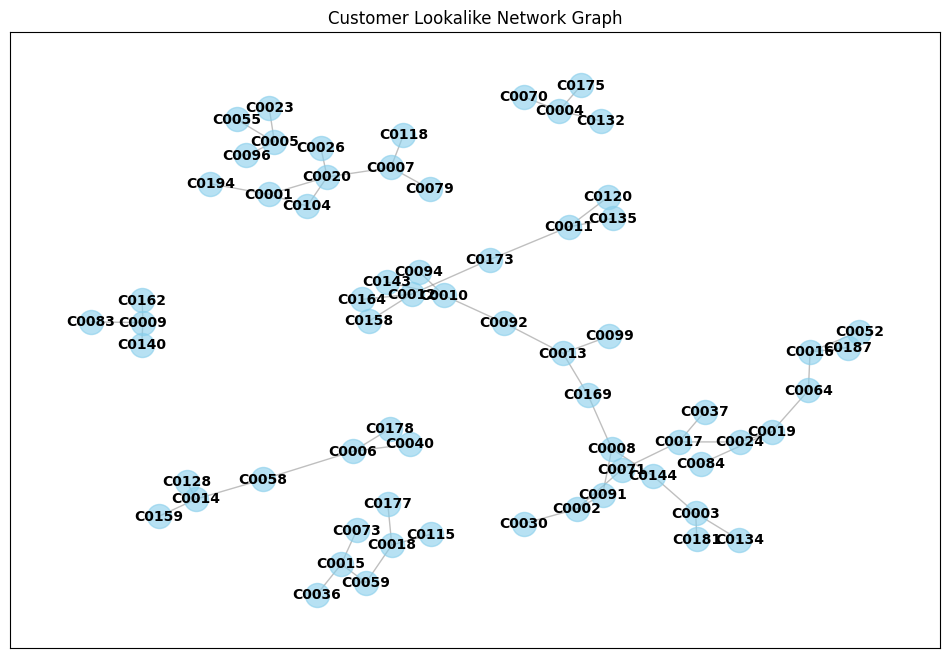

In [17]:
import networkx as nx

# Create a graph
G = nx.Graph()

# Add nodes for each customer
for customer_id in lookalike_df["CustomerID"].unique():
    G.add_node(customer_id)

# Add edges for lookalike relationships with similarity scores
for _, row in lookalike_df.iterrows():
    G.add_edge(row["CustomerID"], row["LookalikeID"], weight=row["SimilarityScore"])

# Draw the network graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.15)  # Adjust layout for better spacing
nx.draw_networkx_nodes(G, pos, node_size=300, node_color='skyblue', alpha=0.6)
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5, edge_color='grey')
nx.draw_networkx_labels(G, pos, font_size=10, font_weight="bold")
plt.title("Customer Lookalike Network Graph")
plt.show()


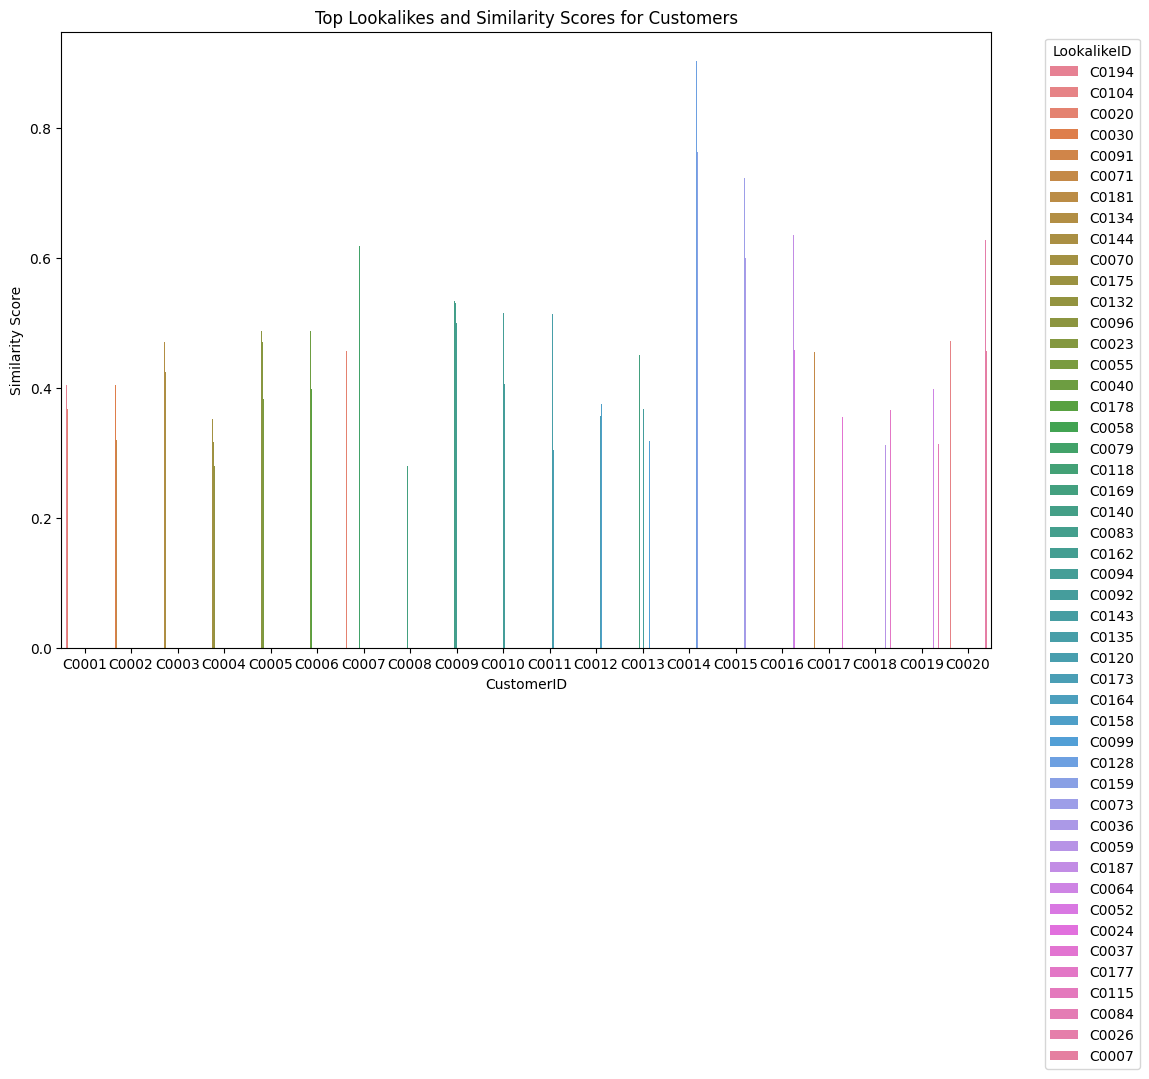

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a DataFrame for visualization
lookalike_df = pd.DataFrame(output_data, columns=["CustomerID", "LookalikeID", "SimilarityScore"])

plt.figure(figsize=(12, 8))

# Plot a clustered bar chart for top 3 lookalikes of each customer
sns.barplot(x="CustomerID", y="SimilarityScore", hue="LookalikeID", data=lookalike_df, dodge=True)

plt.title("Top Lookalikes and Similarity Scores for Customers")
plt.xlabel("CustomerID")
plt.ylabel("Similarity Score")
plt.legend(title="LookalikeID", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


#### Save the output to a csv

In [10]:
output_data = []
for customer_id, lookalikes in lookalike_map.items():
    for lookalike in lookalikes:
        output_data.append(
            [customer_id, lookalike["LookalikeID"], lookalike["SimilarityScore"]]
        )


In [11]:
output_df = pd.DataFrame(output_data, columns=["CustomerID", "LookalikeID", "SimilarityScore"])
output_df.to_csv("Lookalike.csv", index=False)